In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Start here**

## CNN for classifying fracture bones and non-fracture bones
- **Fructure** ( كسر)
- **non-fructure** (لا يوجد كسر)



In [2]:
pip install split-folders


In [3]:
# ============================================================
# 1) Imports + Settings
# ============================================================
import os, random, copy, itertools, pathlib, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
# new below library


#import splitfolders
from torchsummary import summary

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


Device: cuda


## 2) Paths




In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pathlib, os
import pandas as pd

RAW_DATA_DIR = pathlib.Path('/content/drive/MyDrive/Project/dataSet') ##

print("RAW_DATA_DIR exists:", RAW_DATA_DIR.exists())
print("RAW_DATA_DIR:", RAW_DATA_DIR)


RAW_DATA_DIR exists: True
RAW_DATA_DIR: /content/drive/MyDrive/Project/dataSet


In [7]:
if RAW_DATA_DIR.exists():
    print("\nFolders (classes) in RAW_DATA_DIR:")
    for p in RAW_DATA_DIR.iterdir():
        if p.is_dir():
            print("-", p.name)



Folders (classes) in RAW_DATA_DIR:
- Fractured
- Non_fractured


In [8]:
RAW_DATA_DIR = pathlib.Path("/content/drive/MyDrive/Project/dataSet")
print(RAW_DATA_DIR.exists(), RAW_DATA_DIR)


True /content/drive/MyDrive/Project/dataSet


In [9]:
for cls in RAW_DATA_DIR.iterdir():
    if cls.is_dir():
        files = list(cls.glob('*'))[:10]
        print(cls.name, "->", len(files), "sample files:")
        for f in files[:3]:
            print("   ", f.name)

Fractured -> 10 sample files:
    93-rotated2-rotated3-rotated3.jpg
    93-rotated2-rotated1-rotated1 - Copy (1).jpg
    93-rotated2-rotated1-rotated1 (1).jpg
Non_fractured -> 10 sample files:
    57-rotated3 (1).jpg
    6-rotated1-rotated2 (1).jpg
    6-rotated3 (1).jpg


## 3) تقسيم البيانات Train / Val باستخدام splitfolders

- تقسيم 80% تدريب، 20% تحقق
- ينتج مجلد جديد: `/kaggle/working/brain/`


In [10]:
# ============================================================
# 3) Split dataset (80/20)
# ============================================================
import splitfolders

OUT_DIR = pathlib.Path("/content/fracture_split") #split d twice

if not OUT_DIR.exists():
    splitfolders.ratio(
        RAW_DATA_DIR,
        output=str(OUT_DIR),
        seed=20,
        ratio=(0.8, 0.2)
    )
    print("Split done ✅")
else:
    print("Split already exists ✅")

TRAIN_DIR = OUT_DIR / "train"
VAL_DIR   = OUT_DIR / "val"

print("Train:", TRAIN_DIR)
print("Val  :", VAL_DIR)


Copying files: 11671 files [05:39, 34.39 files/s] 

Split done ✅
Train: /content/fracture_split/train
Val  : /content/fracture_split/val


## 4) Transforms: Augmentation + Normalization

- Resize 256×256
- Augmentation للتدريب: flips + rotation
- Normalize بقيم ImageNet (شائع لصور RGB)


In [11]:
# ============================================================
# 4) Transforms
# ============================================================
IMG_SIZE = 256
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    #augmentation (same as making noises)
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5), # 50% of pictures will be flipped
    transforms.RandomVerticalFlip(p=0.5),   # 50% of pictures will be flipped
    transforms.RandomRotation(30), # rotatee between -30 to 30 randomly
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


## 5) تحميل البيانات بـ ImageFolder

ImageFolder يقرأ الصور من المجلدات ويحول اسم المجلد إلى label تلقائيًا.


In [12]:
# ============================================================
# 5) Datasets
# ============================================================
train_set = ImageFolder(TRAIN_DIR, transform=train_transform)
val_set   = ImageFolder(VAL_DIR,   transform=val_transform)

print("Classes:", train_set.classes)
print("class_to_idx:", train_set.class_to_idx)
print("Train size:", len(train_set))
print("Val size  :", len(val_set))


Classes: ['Fractured', 'Non_fractured']
class_to_idx: {'Fractured': 0, 'Non_fractured': 1}
Train size: 9336
Val size  : 2335


## 6) عرض عينات (مع Un-normalize للعرض)

Normalize يخلي العرض “غامق/غريب”، لذلك نرجع القيم مؤقتًا.


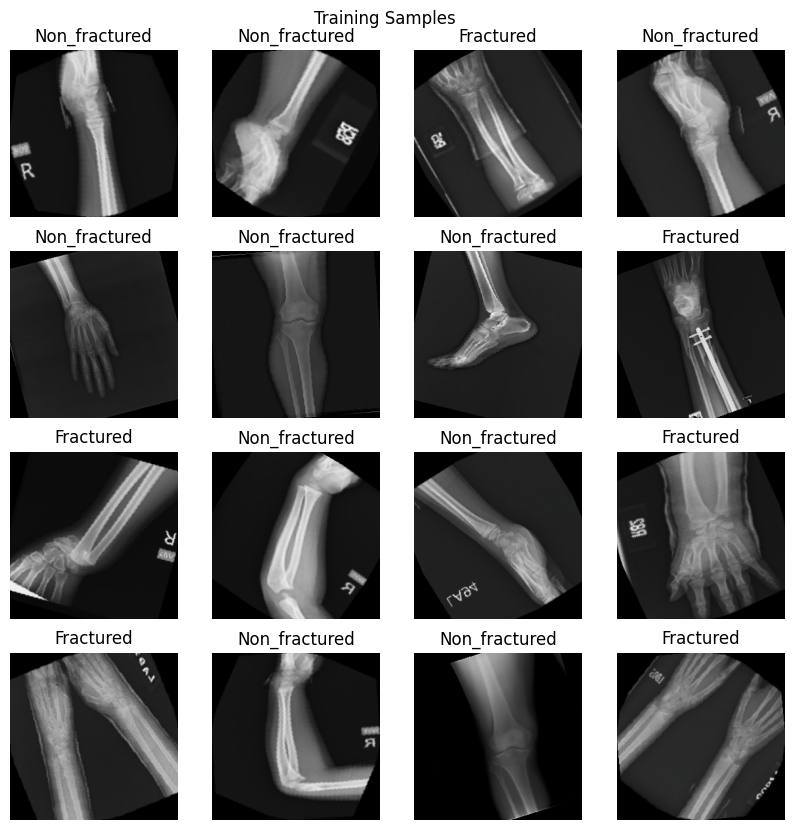

In [13]:
# ============================================================
# 6) Visualize samples
# ============================================================
idx_to_class = {v:k for k,v in train_set.class_to_idx.items()}

def unnormalize(img_tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    img = img_tensor.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return torch.clamp(img, 0, 1)

plt.figure(figsize=(10, 10))
rows, cols = 4, 4
for i in range(rows * cols):
    idx = random.randint(0, len(train_set)-1)
    img, label = train_set[idx]
    img_show = unnormalize(img).permute(1, 2, 0).cpu().numpy()
    plt.subplot(rows, cols, i+1)
    plt.imshow(img_show)
    plt.axis('off')
    plt.title(idx_to_class[int(label)])
plt.suptitle("Training Samples", y=0.92)
plt.show()


## 7) DataLoaders

- train: shuffle=True
- val: shuffle=False


In [14]:
# handling wrong images in the data set and ignores that
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True ## اذا الصوره فيها مشاكل تسوي لها تجاهل
# ============================================================
# 7) DataLoaders
# ============================================================
BATCH_SIZE = 64
NUM_WORKERS = 2

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)  #why pin memory?
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

xb, yb = next(iter(train_loader))
print("X batch:", xb.shape)  # [B,3,256,256]
print("y batch:", yb.shape, yb.dtype)


X batch: torch.Size([64, 3, 256, 256])
y batch: torch.Size([64]) torch.int64


## 8) بناء CNN Model (4 Conv + Pool + FC)

> سنرجع logits ثم نستخدم CrossEntropyLoss.


In [15]:
# ============================================================
# 8) CNN Model
# ============================================================
class CNN_TUMOR(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.30): # كان 0 وزدناه الى 0.3
        super().__init__()
        self.dropout_rate = dropout_rate

        self.conv1 = nn.Conv2d(3, 8,  kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16,32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32,64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64,128,kernel_size=3, padding=1) ## extra layer
        self.pool = nn.MaxPool2d(2,2)

        with torch.no_grad():
            dummy = torch.zeros(1,3,IMG_SIZE,IMG_SIZE)
            x = self._forward_features(dummy)  # first initlization for x

            self.flatten_dim = x.view(1,-1).shape[1]

        self.fc1 = nn.Linear(self.flatten_dim, 100)
        self.fc2 = nn.Linear(100, num_classes) # 2 classes

    def _forward_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))   ## extra one
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x)) # prediction (activating function ?
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        logits = self.fc2(x)
        return logits

model = CNN_TUMOR(num_classes=len(train_set.classes)).to(device)
summary(model, input_size=(3, IMG_SIZE, IMG_SIZE), device=device.type)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             224
         MaxPool2d-2          [-1, 8, 128, 128]               0
            Conv2d-3         [-1, 16, 128, 128]           1,168
         MaxPool2d-4           [-1, 16, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]           4,640
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Linear-11                  [-1, 100]         819,300
           Linear-12                    [-1, 2]             202
Total params: 917,886
Trainable params: 917,886
Non-trainable params: 0
-------------------------------

## 9) Loss + Optimizer + Scheduler

In [16]:
# ============================================================
# 9) Training components
# ============================================================
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=3e-4)   # كان 0.0003 وقللناه الى 0.00003

scheduler = ReduceLROnPlateau(  # function belong to which lib?
    optimizer, mode='min', factor=0.5, patience=5
)

BEST_PATH = "fracture_and_non_fracture_best_state.pt"


## 10) دوال التدريب والتقييم (Epoch)

سنحسب:
- Loss
- Accuracy
- F1-score


In [17]:
# ============================================================
# 10) Train/Eval helpers
# ============================================================
def _f1_avg():
    # إذا ثنائي => binary، إذا متعدد => macro
    return 'binary' if len(train_set.classes)==2 else 'macro'

def train_one_epoch(model, loader):
    model.train()
    losses=[]
    all_true, all_pred = [], []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)  # avoid softmax
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        preds = torch.argmax(logits, dim=1)
        all_true.extend(y.detach().cpu().numpy())
        all_pred.extend(preds.detach().cpu().numpy())

    avg_loss = float(np.mean(losses))
    acc = accuracy_score(all_true, all_pred)
    f1  = f1_score(all_true, all_pred, average=_f1_avg())
    return avg_loss, acc, f1

@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    losses=[]
    all_true, all_pred = [], []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        losses.append(loss.item())

        preds = torch.argmax(logits, dim=1)
        all_true.extend(y.detach().cpu().numpy())
        all_pred.extend(preds.detach().cpu().numpy())

    avg_loss = float(np.mean(losses))
    acc = accuracy_score(all_true, all_pred)
    f1  = f1_score(all_true, all_pred, average=_f1_avg())
    return avg_loss, acc, f1


## 11) Training Loop + حفظ أفضل وزن

In [18]:
# ============================================================
# 11) Training loop
# ============================================================
EPOCHS = 50

history = {"train_loss":[], "val_loss":[],
           "train_acc":[],  "val_acc":[],
           "train_f1":[],   "val_f1":[]}

best_val_loss = float('inf')
best_wts = copy.deepcopy(model.state_dict())

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_f1 = train_one_epoch(model, train_loader)
    va_loss, va_acc, va_f1 = eval_one_epoch(model, val_loader)

    scheduler.step(va_loss)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)
    history["train_f1"].append(tr_f1)
    history["val_f1"].append(va_f1)

    if va_loss < best_val_loss:
        best_val_loss = va_loss
        best_wts = copy.deepcopy(model.state_dict())
        torch.save(best_wts, BEST_PATH)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} | "
          f"val_loss {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f}")


Epoch 01/50 | train_loss 0.6222 acc 0.6415 f1 0.6805 | val_loss 0.5464 acc 0.7105 f1 0.7374
Epoch 02/50 | train_loss 0.5501 acc 0.7228 f1 0.7536 | val_loss 0.5294 acc 0.7173 f1 0.7646
Epoch 03/50 | train_loss 0.5258 acc 0.7403 f1 0.7679 | val_loss 0.5295 acc 0.7272 f1 0.7207
Epoch 04/50 | train_loss 0.4953 acc 0.7586 f1 0.7846 | val_loss 0.4926 acc 0.7602 f1 0.7595
Epoch 05/50 | train_loss 0.4668 acc 0.7782 f1 0.7972 | val_loss 0.4459 acc 0.7897 f1 0.7974
Epoch 06/50 | train_loss 0.4308 acc 0.8011 f1 0.8171 | val_loss 0.3969 acc 0.8184 f1 0.8321
Epoch 07/50 | train_loss 0.4040 acc 0.8202 f1 0.8322 | val_loss 0.3689 acc 0.8368 f1 0.8386
Epoch 08/50 | train_loss 0.3733 acc 0.8339 f1 0.8458 | val_loss 0.3657 acc 0.8394 f1 0.8505
Epoch 09/50 | train_loss 0.3393 acc 0.8507 f1 0.8609 | val_loss 0.3125 acc 0.8625 f1 0.8674
Epoch 10/50 | train_loss 0.3095 acc 0.8679 f1 0.8769 | val_loss 0.2819 acc 0.8827 f1 0.8874
Epoch 11/50 | train_loss 0.2895 acc 0.8805 f1 0.8881 | val_loss 0.2668 acc 0.890

## 12) رسم منحنيات Loss/Acc/F1

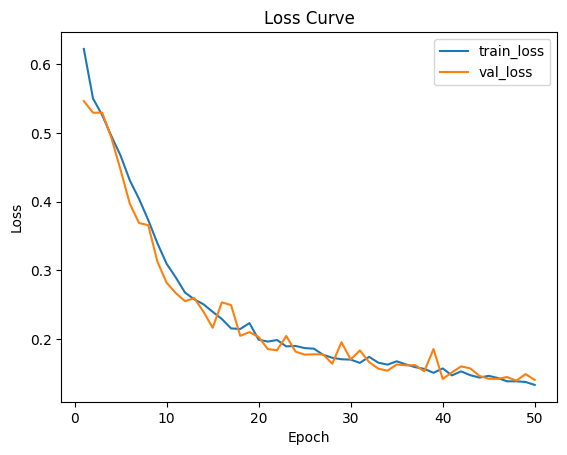

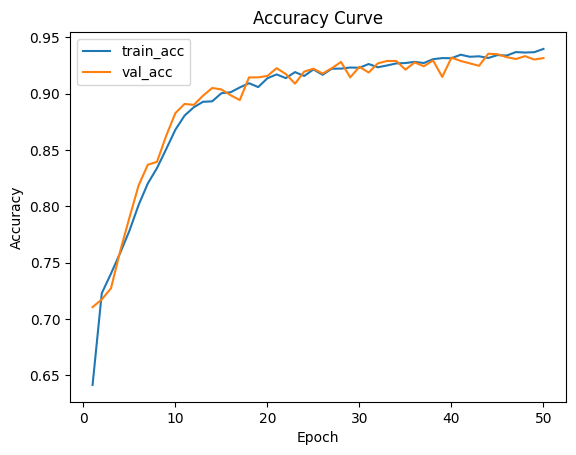

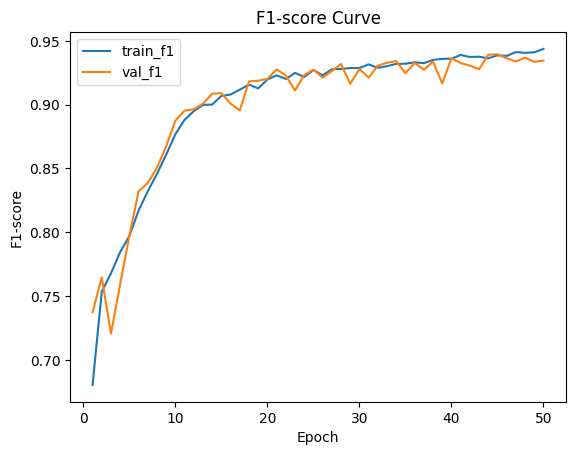

In [19]:
# ============================================================
# 12) Plot curves
# ============================================================
epochs = np.arange(1, EPOCHS+1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="train_loss")
plt.plot(epochs, history["val_loss"], label="val_loss")
plt.title("Loss Curve"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, history["train_acc"], label="train_acc")
plt.plot(epochs, history["val_acc"], label="val_acc")
plt.title("Accuracy Curve"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, history["train_f1"], label="train_f1")
plt.plot(epochs, history["val_f1"], label="val_f1")
plt.title("F1-score Curve"); plt.xlabel("Epoch"); plt.ylabel("F1-score"); plt.legend(); plt.show()


## 13) Evaluation: Classification Report + Confusion Matrix

In [20]:
# ============================================================
# 13) Evaluation
# ============================================================
model.load_state_dict(torch.load(BEST_PATH, map_location=device))
model.eval()

@torch.no_grad()
def get_true_pred(model, loader):
    all_true, all_pred = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_true.extend(y.numpy())
        all_pred.extend(preds)
    return np.array(all_true), np.array(all_pred)

y_true, y_pred = get_true_pred(model, val_loader)

print("Classes:", train_set.classes)
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=train_set.classes))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)


Classes: ['Fractured', 'Non_fractured']

Classification report:

               precision    recall  f1-score   support

    Fractured       0.95      0.91      0.93      1125
Non_fractured       0.92      0.96      0.94      1210

     accuracy                           0.93      2335
    macro avg       0.93      0.93      0.93      2335
 weighted avg       0.93      0.93      0.93      2335

Confusion matrix:
 [[1023  102]
 [  54 1156]]


### رسم Confusion Matrix

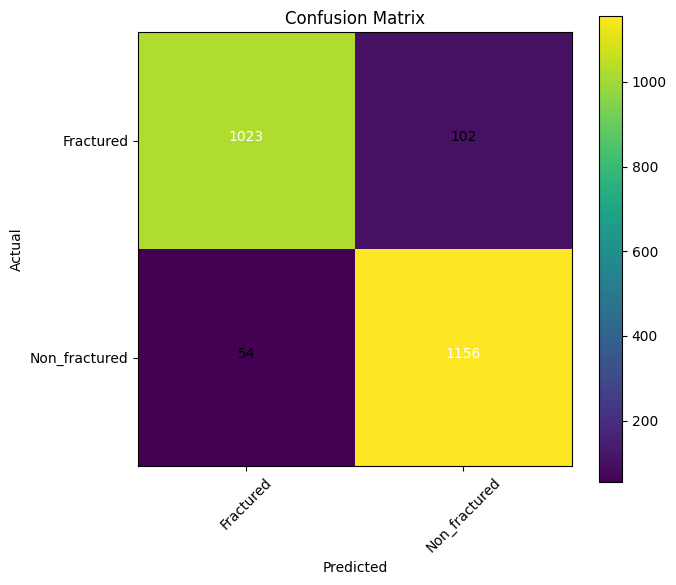

<Figure size 640x480 with 0 Axes>

In [21]:
# ============================================================
# Plot Confusion Matrix
# ============================================================
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()
    plt.savefig('Confusion matrix v1 one 3 epochs')

plot_confusion_matrix(cm, train_set.classes)


In [22]:
# from google.colab import drive
# drive.mount('/content/drive')

## 14) حفظ الموديل

In [23]:
# ============================================================
# 14) Save model
# ============================================================
torch.save(model.state_dict(), "fracture_and_non_fracture_state_dict.pt")
torch.save(model, "fracture_and_non_fracture_full.pt")
print("Saved ✅")


Saved ✅


## للمناقشه
1) لماذا `ImageFolder` مناسب هنا؟  
2) الفرق بين logits و probabilities؟  
3) لماذا نستخدم F1-score؟  
4) كيف نعرف Overfitting من المنحنيات؟


In [24]:
from google.colab import drive
drive.mount('/content/drive')
#lstm gru
# short memory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
